In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import stan  # pystan
import seaborn as sns
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/real_estate2.xlsx")

In [4]:
df.head()

,id,station,distance,space,room,year,type,value
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190


数値化１：築年数に（2018年ベース）

In [5]:
df["elapsed"] = 2018 - df["year"]

数値化２：距離の数値化

In [6]:
df["distance"].unique()

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [7]:
dis_arr = df["distance"].unique()

In [8]:
dis_arr

array(['徒歩10分以内', '徒歩15分以内', '徒歩5分以内', '徒歩15分超', 'バス', '-'], dtype=object)

In [9]:
dis_dict = {dis_arr[0]:10, dis_arr[1]:15, dis_arr[2]:5, dis_arr[3]:20, dis_arr[4]:30, dis_arr[5]:np.nan}

In [10]:
dis_dict

{'徒歩10分以内': 10, '徒歩15分以内': 15, '徒歩5分以内': 5, '徒歩15分超': 20, 'バス': 30, '-': nan}

In [11]:
df["distance2"] = df["distance"].apply(lambda x:dis_dict[x])  # dictで変換

数値化（前処理）の確認として、、、

In [12]:
df.head()

,id,station,distance,space,room,year,type,value,elapsed,distance2
0,1,Y,徒歩10分以内,70,3LDK,1983,-,910,35,10.0
1,2,Y,徒歩10分以内,70,2LDK,1983,D,1120,35,10.0
2,3,Y,徒歩10分以内,70,2LDK,1983,A,1190,35,10.0
3,4,Y,徒歩10分以内,70,4LDK,1983,A,1190,35,10.0
4,5,Y,徒歩10分以内,70,4LDK,1983,A,1190,35,10.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         200 non-null    int64  
 1   station    200 non-null    object 
 2   distance   200 non-null    object 
 3   space      200 non-null    int64  
 4   room       200 non-null    object 
 5   year       200 non-null    int64  
 6   type       200 non-null    object 
 7   value      200 non-null    int64  
 8   elapsed    200 non-null    int64  
 9   distance2  197 non-null    float64
dtypes: float64(1), int64(5), object(4)
memory usage: 15.8+ KB


In [14]:
df = df.dropna()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197 entries, 0 to 199
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         197 non-null    int64  
 1   station    197 non-null    object 
 2   distance   197 non-null    object 
 3   space      197 non-null    int64  
 4   room       197 non-null    object 
 5   year       197 non-null    int64  
 6   type       197 non-null    object 
 7   value      197 non-null    int64  
 8   elapsed    197 non-null    int64  
 9   distance2  197 non-null    float64
dtypes: float64(1), int64(5), object(4)
memory usage: 16.9+ KB


In [16]:
df2 = df[["space","elapsed","distance2","value"]]

In [17]:
df2.head()

,space,elapsed,distance2,value
0,70,35,10.0,910
1,70,35,10.0,1120
2,70,35,10.0,1190
3,70,35,10.0,1190
4,70,35,10.0,1190


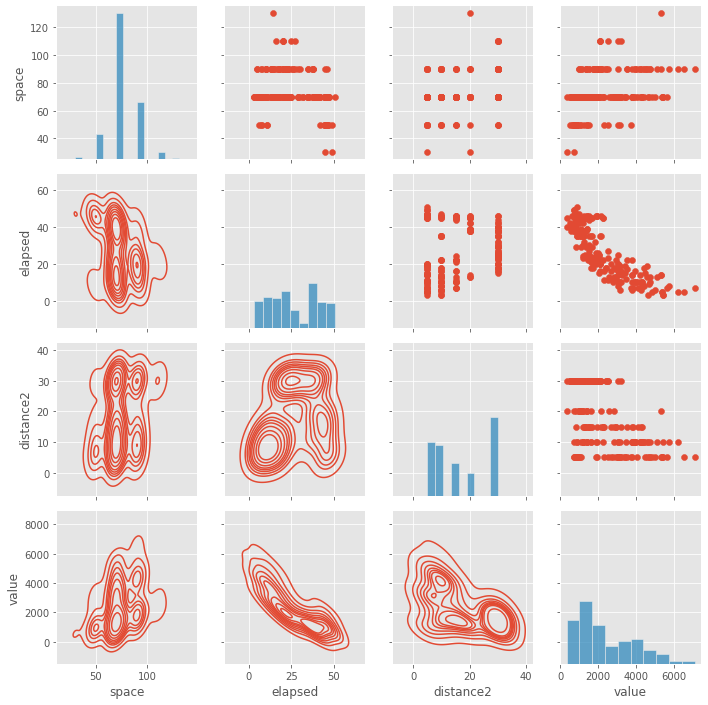

In [18]:
g = sns.PairGrid(df2)
g = g.map_lower(sns.kdeplot)
# g = g.map_diag(sns.distplot, kde=False)  # 対角成分（diag） kde=False -> histになる
g = g.map_diag(sns.histplot)  # 対角成分（diag） kde=False -> histになる
g = g.map_upper(plt.scatter)

In [19]:
stan_model = """
data {
  int N;
  real elapsed[N];
  real dis[N];
  real space[N];
  real Y[N];
}

parameters {
  real d;
  real s;
  real e;
  real b;
  real<lower=0> sigma;
}

model {
  real mu;
  for (n in 1:N){
    mu = e * elapsed[n] + d * dis[n] + s * space[n] + b;
    Y[n] ~ normal(mu, sigma);
  }
}

"""

In [20]:
# stan_data = {"N":df.shape[0],"elapsed":df["elapsed"],"dis":df["distance2"], "space":df["space"], "Y":df["value"]}

stan_data = {"N":df.shape[0],
             "elapsed":df["elapsed"].values,
             "dis":df["distance2"].values, 
             "space":df["space"].values, 
             "Y":df["value"].values}

In [22]:
# sm = pystan.StanModel(model_code=stan_model)
# fit = sm.sampling(data = stan_data, iter=2000, warmup=500, chains=4, seed=123)
# fit

In [23]:
import nest_asyncio
nest_asyncio.apply()

In [46]:
posterior = stan.build(stan_model, data=stan_data, random_seed=123)
fit = posterior.sample(num_chains=4, num_samples=1500, num_warmup=500, save_warmup=0)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_a07_phaz/model_23v7a7lt.stan', line 4, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_a07_phaz/model_23v7a7lt.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_a07_phaz/model_23v7a7lt.stan', line 6, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format

In [24]:
# fig = fit.plot()

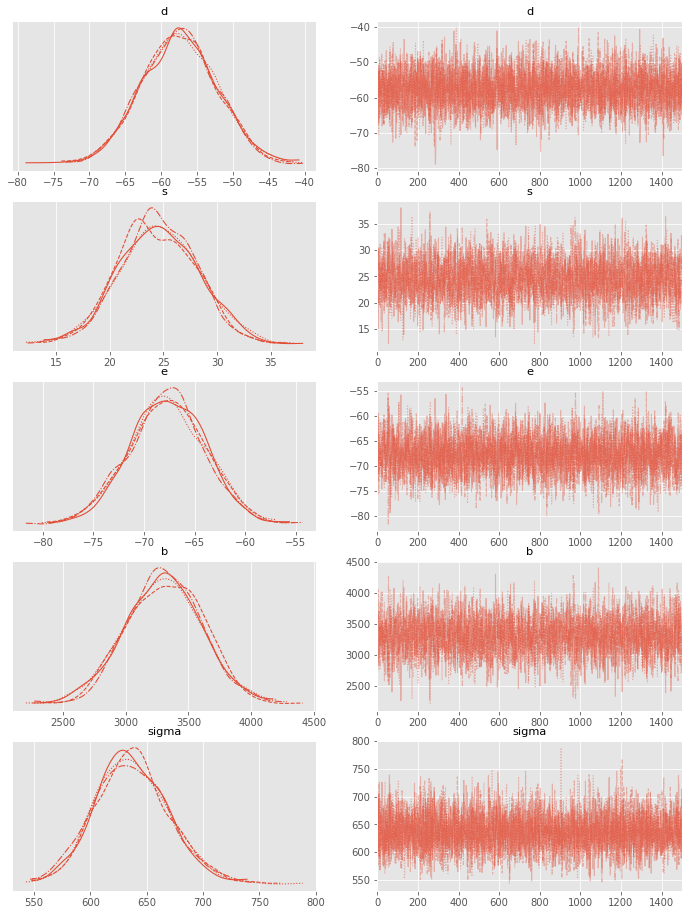

In [47]:
import arviz
arviz.plot_trace(fit, figsize=(12,16),  );  # combined=True, compact=True

In [48]:
df_fit = fit.to_frame()
df_fit.describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
lp__,6000.0,-1363.422671,1.604828,-1373.505623,-1364.251690,-1363.096213,-1362.252434,-1360.882316
accept_stat__,6000.0,0.933049,0.095607,0.111685,0.907986,0.973474,0.995758,1.000000
stepsize__,6000.0,0.116765,0.006449,0.107020,0.113066,0.118141,0.121840,0.123756
treedepth__,6000.0,4.555167,0.720909,1.000000,4.000000,5.000000,5.000000,6.000000
n_leapfrog__,6000.0,29.622667,11.839523,3.000000,31.000000,31.000000,31.000000,63.000000
divergent__,6000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
energy__,6000.0,1365.939353,2.269370,1361.127170,1364.295659,1365.602769,1367.179947,1378.325425
d,6000.0,-57.510842,5.228767,-78.882958,-61.102142,-57.531582,-54.063678,-40.240337
s,6000.0,24.523576,3.651924,12.180139,22.050286,24.424477,27.065391,37.975604


In [49]:
df_fit.shape

(6000, 12)

In [50]:
fit['d'].shape

(1, 6000)